# **Age Estimation**

For this second attemp we split the problem to make it easier to handle

Also, we changed the Dataset used to be the [UTKFace Dataset](https://susanqq.github.io/UTKFace/),
which contains 23K images where each image is labelled with its gender, age and ethinicity.

To make this work you must download it and then rename the directory to `utkface23k` to get rid of the
underscore

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime

## Data processing

To process the data we will acomplish 3 tasks:

- This time we will read the image files as 3-channeled RGB images for training the model, so each array will have a shape of `[img_width, img_height, 3]`.

- Then parse the filename for each image.

- The maximum age is **116** years, so we will use this to make a normalization of the `age` feature.

This time we will make use of the Tensorflow's `tf.data.Dataset` method as it permits to process the data  taking advantage of parallel computing.

In [19]:
# Image size
MODEL_INPUT_IMAGE_SIZE = [200 , 200]

# Number of samples to take from dataset
N = 20000

In [20]:
def parse_image(filename):
    # Read the image from the filename and resize it.
    image_raw = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE) / 255

    # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str )
    # to dtype float32.
    parts = tf.strings.split(tf.strings.split(filename,'/')[2],'_')

    # Normalize
    age = tf.strings.to_number(parts[0]) / 116

    return image, age


# List all the image files in the given directory.
list_ds = tf.data.Dataset.list_files('data/utkface23k/*', shuffle=True)


# Map `parse_image` method to all filenames.
dataset = list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.take(N)

Now we split the dataset, this time without using scikit-learn's train_test_split function, just for fun

In [21]:
# Portion of the dataset to be used for testing.
TRAIN_TEST_SPLIT = 0.3

# Create train and test splits of the dataset.
num_examples_in_test_ds = int(dataset.cardinality().numpy() * TRAIN_TEST_SPLIT)

test_ds = dataset.take(num_examples_in_test_ds)
train_ds = dataset.skip(num_examples_in_test_ds)

print(f"Num examples in train ds {train_ds.cardinality()}")
print(f"Num examples in test ds {test_ds.cardinality()}")

Num examples in train ds 14000
Num examples in test ds 6000


## Building the model

This model performs a number of convolutions on a 4D tensor of images with shape `[None, 200, 200, 3]` in blocks determined by `num_blocks`.

Each block is a sequence of layers with this shape:

- Conv2D
- BatchNorm
- LeakyReLU

For each blocks we apply a number of filters for each layer defined by `num_filters`.

`Dense` layers are added to learn the features extracted by convolutional layers.

Finally, a `Dropout` layer is added to reduce overfitting by dropping a percentage of the convolutional learnt features, whose rate is decreased for each layer,

The network's output is a 2D tensor with shape `[None, 1]`


In [22]:
leaky_relu_alpha = 0.2


def conv(x , num_filters, kernel_size=(3 ,3), strides=1):
    
    x = tf.keras.layers.Conv2D(num_filters,
        kernel_size=kernel_size,
        strides=strides,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.HeNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(1e-5)
    )(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_relu_alpha )(x)
    return x

def dense(x, filters, dropout_rate):
    x = tf.keras.layers.Dense(filters,
        kernel_regularizer=tf.keras.regularizers.L2(0.1),
        bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


num_blocks = 6
num_filters = [16, 32, 64, 128, 256, 256]
kernel_sizes = [3, 3, 3, 3, 3, 3]


inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])


x = inputs
for i in range(num_blocks):
    x = conv(
        x,
        num_filters=num_filters[i],
        kernel_size=kernel_sizes[i])
    x = tf.keras.layers.MaxPooling2D()(x)


x = tf.keras.layers.Flatten()(x)
conv_output = x 


x = dense(conv_output, 256, 0.6)
x = dense(x, 64, 0.4)
x = dense(x, 32, 0.2)
outputs = tf.keras.layers.Dense(1, activation='relu')(x)


model = tf.keras.models.Model(inputs, outputs)


model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 198, 198, 16)      432       
                                                                 
 batch_normalization_12 (Bat  (None, 198, 198, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 32)        4608

## Compiling the model

In [23]:
learning_rate = 0.001
num_epochs = 50
batch_size = 128
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( 
    'checkpoints/age.checkpoint/{epoch:02d}-{val_mae:.2f}.h5', 
    save_best_only=True,
    monitor='val_mae',
    mode='min'
)


# Init TensorBoard Callback
logdir = os.path.join("tb_logs", 'model_age')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)


def scheduler(epochs, learning_rate):
    if epochs < num_epochs * 0.25:
        return learning_rate
    elif epochs < num_epochs * 0.5:
        return 0.0005
    elif epochs < num_epochs * 0.75:
        return 0.0001
    else:
        return 0.000095

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10
)


model.compile( 
    loss=tf.keras.losses.mean_absolute_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate), 
    metrics=['mae']
)

## Train

In [24]:
%load_ext tensorboard
%tensorboard --logdir tb_logs/model_age

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
model.fit( 
    train_ds, 
    epochs=num_epochs,  
    validation_data=test_ds, 
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        lr_schedule_callback,
        early_stopping_callback
    ]
)

Epoch 1/50
110/110 [==============================] - 17s 131ms/step - loss: 13.7382 - mae: 0.2041 - val_loss: 2.2665 - val_mae: 0.1363 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 15s 128ms/step - loss: 0.9160 - mae: 0.1037 - val_loss: 0.3683 - val_mae: 0.1219 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 16s 132ms/step - loss: 0.2209 - mae: 0.0915 - val_loss: 0.1797 - val_mae: 0.1152 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 15s 128ms/step - loss: 0.1304 - mae: 0.0816 - val_loss: 0.1238 - val_mae: 0.0830 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 15s 126ms/step - loss: 0.1149 - mae: 0.0771 - val_loss: 0.1114 - val_mae: 0.0753 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 15s 126ms/step - loss: 0.1072 - mae: 0.0716 - val_loss: 0.1069 - val_mae: 0.0737 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 15s 125ms/step - loss: 0.1042 - mae: 0.0700 - val_loss: 0

## Model evaluation

In [28]:
model.evaluate(test_ds)

47/47 [==============================] - 3s 68ms/step - loss: 0.0471 - mae: 0.0234


[0.04707874730229378, 0.0234133992344141]


Save the Keras model to the local disk, so that we can resume training if needed.


In [29]:
model.save('../models/model_age.h5')

## Validation

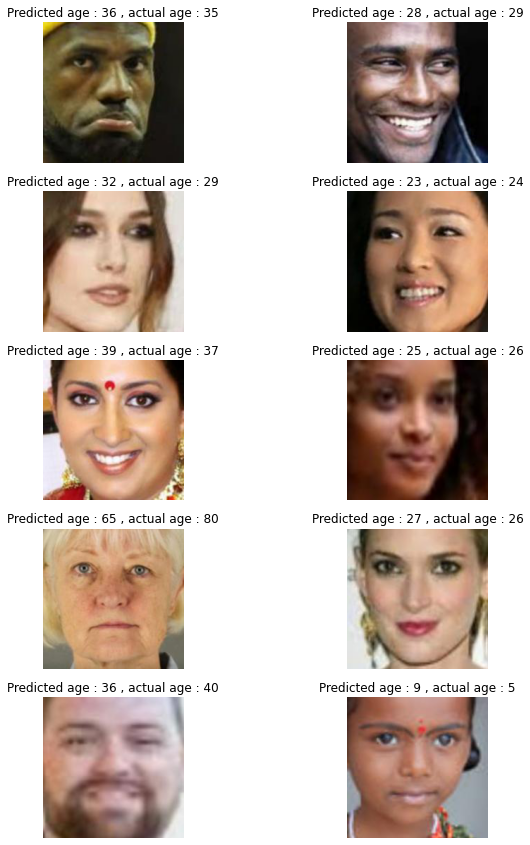

In [30]:
fig = plt.figure(figsize=(10,15))
rows = 5
columns = 2

i = 1
for image, label in test_ds.unbatch().take(10):
    image = image.numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    label_ = int(model.predict(np.expand_dims(image, 0)) * 116)
    plt.axis('off')
    plt.title(f"Predicted age : {label_} , actual age : {int(label.numpy() * 116)}")
    i += 1